# Load up our libraries

In [294]:
# all purpose
import datetime, re
from math import radians, cos, sin, asin, sqrt

# for talking to SQL databases
import psycopg2
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database

# json and XML parsing
import json
from pprint import pprint
from urllib2 import urlopen
from pyquery import PyQuery as pq

# for making maps
import geoplotlib
from geoplotlib.utils import BoundingBox
from IPython.display import Image

# all purpose data analysis and plotting
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# for ML
import patsy
from sklearn.ensemble import RandomForestRegressor
from sklearn import cross_validation, metrics, linear_model, svm
# needed for cross-validation on sets where the test data is not binary/multiclass 
# (i.e. needed for regressors, not classifiers)
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold

# for saving output
import pickle

Define this function for computing distances in meters from (lat,lon) coordinates

In [2]:
# We will need this function to compute the distance between two (lat,lon) points, in meters
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    meters = 6367 * c * 1000
    return meters

Define this sigmoid function to put all the bunching parameters into an interval [0,1]

In [325]:
def tanh_func(normed_pred_diff):
    # do tanh(1/x) so that x = 0 (on top of each other) gets mapped to 1 (bunched)
    # Multiply by 3 to get steeper fall off, 'bunched(0.5) = 0.57 [chosen ad hoc]
    # offset by 0.01 so np doesn't explode its brain at x=0
    return np.tanh(1/(2*(normed_pred_diff+0.001)))

## Load data from SQL database (necessary only to load Muni routes and estlabish connection to database)

We need to connect to the PostgresSQL database that I am reading the NextBus Muni data into, which is called 'sf_muni_arrivals' in our case.

**This cell must be run.**

In [233]:
# MUST BE RUNNING 
# ssh -i ~/.ssh/aws_instance_1_instantiated_2016_01_21.pem -L 63333:localhost:5432 ec2-user@ec2-52-23-196-119.compute-1.amazonaws.com
# for this to work (for that specific AWS instance)
remote_dbname = 'sf_muni_arrivals_aws'
remote_username = 'ec2-user'
remote_table = 'nextbus_realtime_with_predictions_and_freqs'

# Open up an engine, that we will use to create the database if it doesn't exist
engine = create_engine('postgres://%s@localhost:63333/%s'%(remote_username,remote_dbname))

if not database_exists(engine.url):
    create_database(engine.url)
    
# If I want to filter the data first:
# connect:
db_con = None
db_con = psycopg2.connect(database = remote_dbname, user = remote_username, port = 63333, host = 'localhost')

These commands load the entire database into a pandas dataframe. I only used this to grab the list of Muni routes. It is not necessary below.

In [6]:
# the table name is 'nextbus':
# only run this code if the list_of_muni_routes needs to be reestablished
# sql_query = """
# SELECT * FROM {table};
# """.format(table=table)
# nbdata = pd.read_sql_query(sql_query,db_con)

In [4]:
# routeslist = pd.unique(nbdata['route'].ravel())
# list_of_muni_routes = pd.DataFrame(data=routeslist, index = range(len(routeslist)), columns=['route'])

# # Clean up a bit
# list_of_muni_routes = list_of_muni_routes[(list_of_muni_routes.route.isnull() == False) & (list_of_muni_routes.route != 'Inspectors') & (list_of_muni_routes.route != 'Training')]
# list_of_muni_routes = list_of_muni_routes[list_of_muni_routes.route != '']
# np.save('list_of_muni_routes',np.asarray(list_of_muni_routes).ravel())
list_of_muni_routes = np.load('list_of_muni_routes.npy')

## Once table is built above, load that data to compute actual classifier

This cell takes a long time to run since it is pulling the database over the net

In [234]:
sql_query = '''SELECT * FROM {table};'''.format(table=remote_table)
df_all = pd.read_sql_query(sql_query, db_con)

Compose a dictionary, two for each route. For each route, drop all duplicates (taking first and last for first and second part of each dict, respectively). 

In [235]:
bunching_dict={}
for i in list_of_muni_routes:
    my_key1 = 'route_'+str(i)+'_'+str(1)
    my_key2 = 'route_'+str(i)+'_'+str(2)
    if my_key1 not in bunching_dict:
        bunching_dict[my_key1] = 0
    if my_key2 not in bunching_dict:
        bunching_dict[my_key2] = 0 
        
# Declare a total dataframe to take everything in, appending sequentially later
df_total = pd.DataFrame()

In [242]:
kernel = [0.125,0.25,0.5,1,0.5,0.25,0.125]
terms_to_drop = (len(kernel)-1)/2
for route in list_of_muni_routes:
    for i in range(2):
        key = 'route_'+str(route)+'_'+str(i)
        bunching_dict[key] = df_all[df_all.route_x == str(route)]
        #print bunching_dict[key].head(5)
        if i == 0:
            bunching_dict[key] = bunching_dict[key].drop_duplicates(subset='time', keep='first')
        elif i == 1:
            bunching_dict[key] = bunching_dict[key].drop_duplicates(subset='time', keep='last')
        if not bunching_dict[key].empty:
            bunched_tmp=map(tanh_func,np.convolve(bunching_dict[key]['normed_pred_diff'],kernel)/sum(kernel))
            bunched_tmp=bunched_tmp[terms_to_drop:]
            bunched_tmp=bunched_tmp[:-terms_to_drop]
            bunching_dict[key]['bunched'] = bunched_tmp
            df_total = df_total.append(bunching_dict[key])   

In [243]:
print df_all.shape
print df_total.shape

(304446, 15)
(139944, 16)


Look at some of the routes as they are distributed in the bunching parameter:

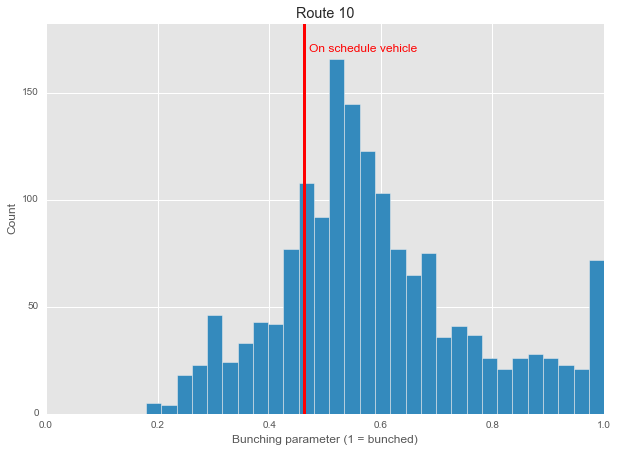

In [327]:
# This gives the 'perfectly on-time' bunch value
on_time_value = tanh_func(1)
#rand_route = np.random.choice(np.asarray(list_of_muni_routes))
rand_route = 10
#print rand_route

#tmp_height, tmp_bins = np.histogram(df_total['bunched'], bins=30)
tmp_height, tmp_bins = np.histogram(df_total[df_total.route_x == str(rand_route)]['bunched'], bins=30)
plt.style.use('ggplot')
f,a = plt.subplots()
f.set_size_inches(10,7)
width = tmp_bins[1]-tmp_bins[0]
a.bar(tmp_bins[:-1], tmp_height, width = width)
#a.bar(tmp_bins_30[:-1], tmp_height_30, width = width, color='r')
a.set_xlabel('Bunching parameter (1 = bunched)')
a.set_ylabel('Count')
a.set_xlim(0,1)
a.set_ylim(0,max(tmp_height)*1.1)
plt.plot((on_time_value, on_time_value), (0, max(tmp_height)*1.1), 'k-', linewidth=3, color='r')
a.text(0.665, 0.92, 'On schedule vehicle',
        verticalalignment='bottom', horizontalalignment='right',
        transform=a.transAxes,
        color='red', fontsize=12)
a.set_title('Route '+str(rand_route))

In [321]:
cor_mat = df_total[['time','lat_x','lon_x','route_x','speed_x','time','lat_y','lon_y','speed_y','dist','freq','bunched']].corr()

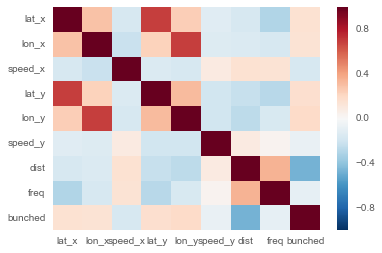

In [322]:
sns.heatmap(cor_mat)

In [159]:
df_all.columns.values

array(['level_0', 'index', 'lat_x', 'lon_x', 'pred_x', 'route_x',
       'speed_x', 'time', 'lat_y', 'lon_y', 'pred_y', 'speed_y', 'dist',
       'freq', 'normed_pred_diff', 'bunched'], dtype=object)

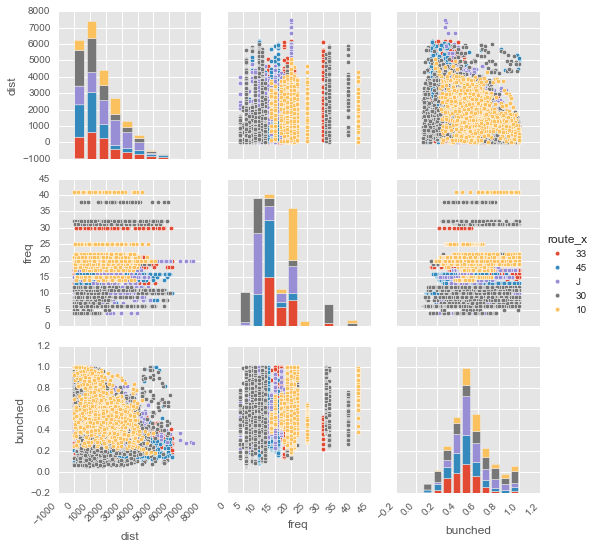

In [258]:
# prettier plot
plt.style.use('ggplot')
df_temp = df_total[(df_total.route_x == '10') | (df_total.route_x == '30') | (df_total.route_x == '45') | (df_total.route_x == 'J') | (df_total.route_x == '33')]
df_temp = df_temp[['route_x','dist','freq', 'bunched']]
# subsample so we can look at more reasonable routes
#
plot = sns.pairplot(df_temp, hue = 'route_x')
for ax in plot.axes.flat:
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, horizontalalignment='right')

### Look at autocorrelation of predictions

In [278]:
tmp = df_total[['pred_x']].astype(float)
tmp_autocorr = tmp['pred_x'].autocorr()

In [283]:
np.corrcoef(tmp['pred_x'][1:-1], tmp['pred_x'][2:])

array([[ 1.        ,  0.91015948],
       [ 0.91015948,  1.        ]])

In [285]:
tmp['pred_x'][2:]

16         6
24         4
32         2
40        25
48        24
56        22
64        22
72        20
80        18
88        16
96        14
104       11
112        8
120        6
128        5
136        4
144        0
152        0
160       15
168       13
176       12
184        9
192        7
200        7
208        5
216        4
224        1
232       20
240       18
248       17
          ..
304359    37
304363    36
304367    35
304371    32
304375    31
304379    31
304383    32
304387    31
304391    31
304395    31
304398    30
304401    29
304404    28
304407    27
304410    25
304413    23
304416    21
304419    20
304422    19
304425    17
304427    15
304429    13
304431    11
304433     9
304435     7
304437     5
304439     4
304441     3
304443     2
304445     0
Name: pred_x, dtype: float64

## Perform random forest fit

In [344]:
len(df_total.columns.values)

16

In [286]:
# Create the random forest object which will include all the parameters
# for the fit
# n_estimators = [10,100,1000]
# max_depth = [1, 4, 8]
# max_features = (also called p) = up to sqrt(number of features)
# grid search cv ( look up in sklearn):
# GridSearchCV(RandomForest(), dict_of_parameters, x= Xtrain, y = Ytrain, CV= 10)
# (or do with kNN Regression)
# also kNN regressor, start with k=10 and go up and down (k=1 is the definition of overfitting)
# kNN is very good at getting odd shapes (for odd shapes use smaller k), but can overfit at small k because
# it partitions the data exactly with each data point in the training set 
n_esimators = 250
max_depth = 4
max_features = np.sqrt(len(df_total.columns.values))
forest = RandomForestRegressor(n_estimators = n_estimators,, max_depth=max_depth, max_features=max_features)

Separate the data into training and testing

In [304]:
# Reserve 0.4 of data for testing
test_data = df_total.sample(frac=0.4, replace=False)
# 0.6 for training
train_data = df_total.loc[~df_total.index.isin(test_data.index)]

# Instead could do this with test_train_split
#train_test_split()
# np.random.seed(1)
# self.df = self.df.reindex(np.random.permutation(self.df.index))
# self.df = self.df.reset_index().drop('index', axis = 1)
# X = self.df.as_matrix(self.df.columns[:-1])
# y = self.df.as_matrix(['price'])[:,0]
# xtrain, xtest, ytrain, ytest = train_test_split(
#                                         X, y,
#                                         test_size=self.test_size,

**Taking out categorical variable for now on route_x-- but this should definitely be included once I learn to include this with individual points**

(One trick when computing probs on individual points would be to add dummy rows that iterate over all routes, so all categories are there, then only take the prediction on the first row)


There is a much better way of doing this- use sklearn's 'one hot encoding,' which does exactly what I am talking about automatically.

In [289]:
#formula = 'bunched ~ time.dt.hour + time.dt.minute + lat_x + lon_x + speed_x + C(route_x) + lat_y + lon_y + speed_y + dist_percentile'
formula = 'bunched ~ time.dt.hour + time.dt.minute + lat_x + lon_x + speed_x  + lat_y + lon_y + speed_y + dist + freq'


# do with the training data
ytrain, xtrain = patsy.dmatrices(formula, data=train_data, return_type='dataframe')
ytrain = np.asarray(ytrain).ravel()

# same with the test data
ytest, xtest = patsy.dmatrices(formula, data=test_data, return_type='dataframe')
ytest = np.asarray(ytest).ravel()

In [290]:
# Fit the training data to the Survived labels and create the decision trees
forest = forest.fit(xtrain,ytrain)

# Take the same decision trees and run it on the test data
#output = forest.predict(test_data)

In [339]:
forest.predict(xtest.loc[0].reshape(1,-1))[0]

0.30102607018970373

In [340]:
xtest.head()

,Intercept,time.dt.hour,time.dt.minute,lat_x,lon_x,speed_x,lat_y,lon_y,speed_y,dist,freq
139328,1,23,20,37.77828,-122.39160,0,37.77995,-122.389530,27,250.591604,10
215323,1,0,36,37.76624,-122.40047,38,37.76583,-122.407570,25,789.365993,15
292911,1,15,42,37.76339,-122.44367,24,37.76590,-122.442360,12,208.761625,15
92733,1,15,16,37.78655,-122.40589,27,37.78242,-122.446014,14,4465.570088,8
19893,1,14,25,37.75319,-122.47643,25,37.80498,-122.425010,0,6495.124346,20


Store the fit in memeory so I don't have to load it every time.

Update: apparently this is 2.7G in size. Bad idea.

In [331]:
today = !date '+%Y_%m_%d'
savefile = 'rf_fit_'+str(today[0])+'.pkl'

with open(savefile,'wb') as output:
    pickle.dump(forest, output, pickle.HIGHEST_PROTOCOL)

Let's look at the accuracy and compute the RMSE

In [291]:
# Compute predictions for each value
preds = forest.predict(xtest)
rmse = metrics.mean_squared_error(preds, ytest)**0.5
print 'RMSE for model is: {0}'.format(rmse)

RMSE for model is: 0.111805086017


Let's do it with cross validation as well, and get an average (using a bit of Anthony's code here)

In [341]:
cv = KFold(n = xtrain.shape[0], n_folds = 3)
rfr = RandomForestRegressor(n_estimators = 250)
rmse_cv = []
results = {'pred': [],
           'real': []}

for train, test in cv:
#     print np.asarray(train)
#     print len(train)
#     print len(test)
#     print len(train)+len(test)-len(xtrain)
    rfr.fit(xtrain[train], ytrain[train])
    pred = rfr.predict(xtrain[test])
    error = mean_squared_error(pred, ytrain[test])**0.5
    results['pred'] += list(pred)
    results['real'] += list(ytrain[test])
    rmse_cv += [error]
print 'RMSE Scores:', rmse_cv
print 'Mean RMSE:', np.mean(rmse_cv)


IndexError: indices are out-of-bounds

In [303]:
xtrain

,Intercept,time.dt.hour,time.dt.minute,lat_x,lon_x,speed_x,lat_y,lon_y,speed_y,dist,freq
16,1,2,26,37.77861,-122.48460,33,37.73876,-122.49411,29,2602.844088,12
184,1,3,4,37.77245,-122.48415,12,37.73474,-122.49384,14,2495.197331,12
216,1,3,11,37.78474,-122.48509,42,37.75213,-122.49506,27,2239.746759,10
332,1,3,37,37.78797,-122.48313,44,37.77994,-122.48466,0,508.505444,10
398,1,3,53,37.75971,-122.49558,24,37.72149,-122.47235,0,3444.829900,12
404,1,3,55,37.76318,-122.49269,46,37.72126,-122.47495,0,3185.184604,12
411,1,3,57,37.72473,-122.47495,33,37.72257,-122.43471,27,4473.529373,14
423,1,4,0,37.76953,-122.47894,20,37.72712,-122.48261,53,2563.509070,14
485,1,4,14,37.76490,-122.48886,18,37.72143,-122.47237,14,3176.045927,11
506,1,4,19,37.76547,-122.47747,0,37.72679,-122.47486,0,2326.129650,11


Now let's compute the R^2 value, which is a bit easier to understand and contextualize.

On the test set:

In [293]:
slope, intercept, r_value, p_value, std_err = stats.linregress(ytest,preds)
print "r-squared for test set:", r_value**2 

r-squared for test set: 0.675689506965


In [ ]:
# Turn this into an adjusted R^2:
# https://en.wikipedia.org/wiki/Coefficient_of_determination#Adjusted_R2

On the k-folded cross validation:

We can also look at a scatter of predicted bunching values versus actual

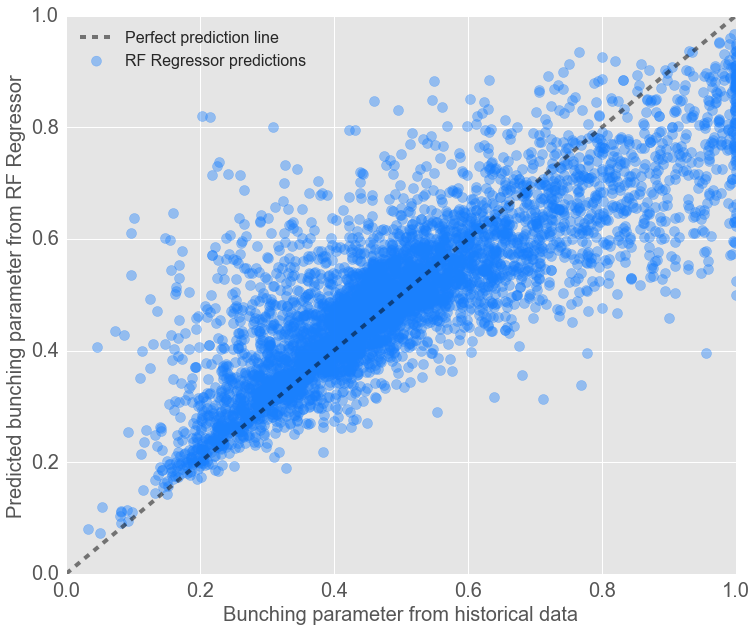

In [329]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize = (12,10))

# reduce the number of points we are plotting
rand_index = np.random.choice(np.arange(len(ytest)), 5000, replace=False)
y_tmp = ytest[rand_index]
pred_tmp = preds[rand_index]

#(0.6,0.0,0.2)
ax.scatter(y_tmp, pred_tmp, color = (.1,.5,1),
           label = 'RF Regressor predictions',
           s = 100, alpha = 0.4)
ax.plot([0,1],[0,1],'k--', label='Perfect prediction line', color = 'black', lw = 4, alpha = 0.5)
# ax.plot(np.arange(0, 1),np.arange(0, 1), color = 'black',
#            label = 'Perfect Prediction Line',
#            lw = 4, alpha = 0.5, ls = 'dashed')

ax.set_xlabel('Bunching parameter from historical data',fontsize = 20)
ax.set_ylabel('Predicted bunching parameter from RF Regressor', fontsize = 20)
#ax.set_title('Results from Test Set', fontsize = 25)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.legend(loc=2, fontsize = 16)
ax.tick_params(labelsize =20)

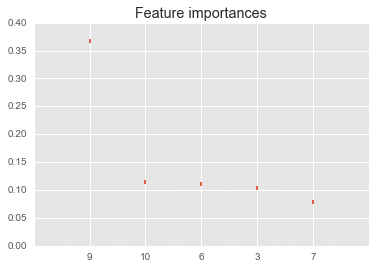

In [330]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
# reverses sorted indices so largest are first
indices = np.argsort(importances)[::-1]
#print indices

# # Print the feature ranking
# print("Feature ranking:")

# for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
features_to_keep = 5
yerr=std[indices][:features_to_keep]
heights= importances[indices][:features_to_keep]
indices = indices[:features_to_keep]
plt.figure()
plt.title("Feature importances")
plt.bar(range(features_to_keep), heights ,
       color=(), yerr=yerr, align="center")
#plt.xticks(range(xtrain.shape[1]), indices)
plt.xticks(range(len(indices)), indices)
#plt.xlim([-1, xtrain.shape[1]])
#plt.xlim([-1, 8])
plt.show()

## Attempt with kNN Regression

In [345]:
from sklearn import neighbors

## Use grid search to iterate over parameters from previous two methods

## Attempt with logit regression

In [ ]:
from sklearn import Logi

In [ ]:
# Create the random forest object which will include all the parameters
# for the fit
logit = RandomForestRegressor(n_estimators = 250)

## Older fit attempts

In [331]:
plt.savefig('feature_importance_rf_2016_01_21.png')

Saving the RF fit to disk, use pickle:

with open('name.pickle','wb') as f:
   pickle.dump(obj, f)

In [332]:
import pickle

In [333]:
with open('rf_fit_2016_01_21.pkl','wb') as output:
    pickle.dump(forest, output, pickle.HIGHEST_PROTOCOL)
    
# and when I want it later
with open('rf_fit_2016_01_21.pkl','rb') as input:
    forest = pickle.load(input)